Nick Harris  
Fellowship.ai image segmentation challenge  
The project will apply a pre-trained segmentation model to the _CelebA_ dataset.

In [8]:
import numpy as np 
import pandas as pd #easy DF imports
import os #path handling
import matplotlib.pyplot as plt
import seaborn as sns #good functionality on top of matplotlib
import cv2
from shutil import move
import tensorflow as tf

In [4]:
#Importing annotations first to perform EDA in order to see general distribution of various attributes seen in these images. 
pathbase=r"C:\Users\nickh\fellowshipAI" #harcoded because notebook stored in git folder, images/annotations local
attr_path=r"images\annotations\list_attr_celeba.txt"
celeb_attr=pd.read_csv(os.sep.join([pathbase, attr_path]), sep=" +", header=1, engine='python')
attr_tidy=celeb_attr.melt(var_name='attribute') #data needs to be tidy for easy graphing with seaborn

In [6]:
print(celeb_attr.info())
#Just verifying there aren't null entries in attribute dataset

<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 40 columns):
5_o_Clock_Shadow       202599 non-null int64
Arched_Eyebrows        202599 non-null int64
Attractive             202599 non-null int64
Bags_Under_Eyes        202599 non-null int64
Bald                   202599 non-null int64
Bangs                  202599 non-null int64
Big_Lips               202599 non-null int64
Big_Nose               202599 non-null int64
Black_Hair             202599 non-null int64
Blond_Hair             202599 non-null int64
Blurry                 202599 non-null int64
Brown_Hair             202599 non-null int64
Bushy_Eyebrows         202599 non-null int64
Chubby                 202599 non-null int64
Double_Chin            202599 non-null int64
Eyeglasses             202599 non-null int64
Goatee                 202599 non-null int64
Gray_Hair              202599 non-null int64
Heavy_Makeup           202599 non-null int64
High_Cheekbones        202

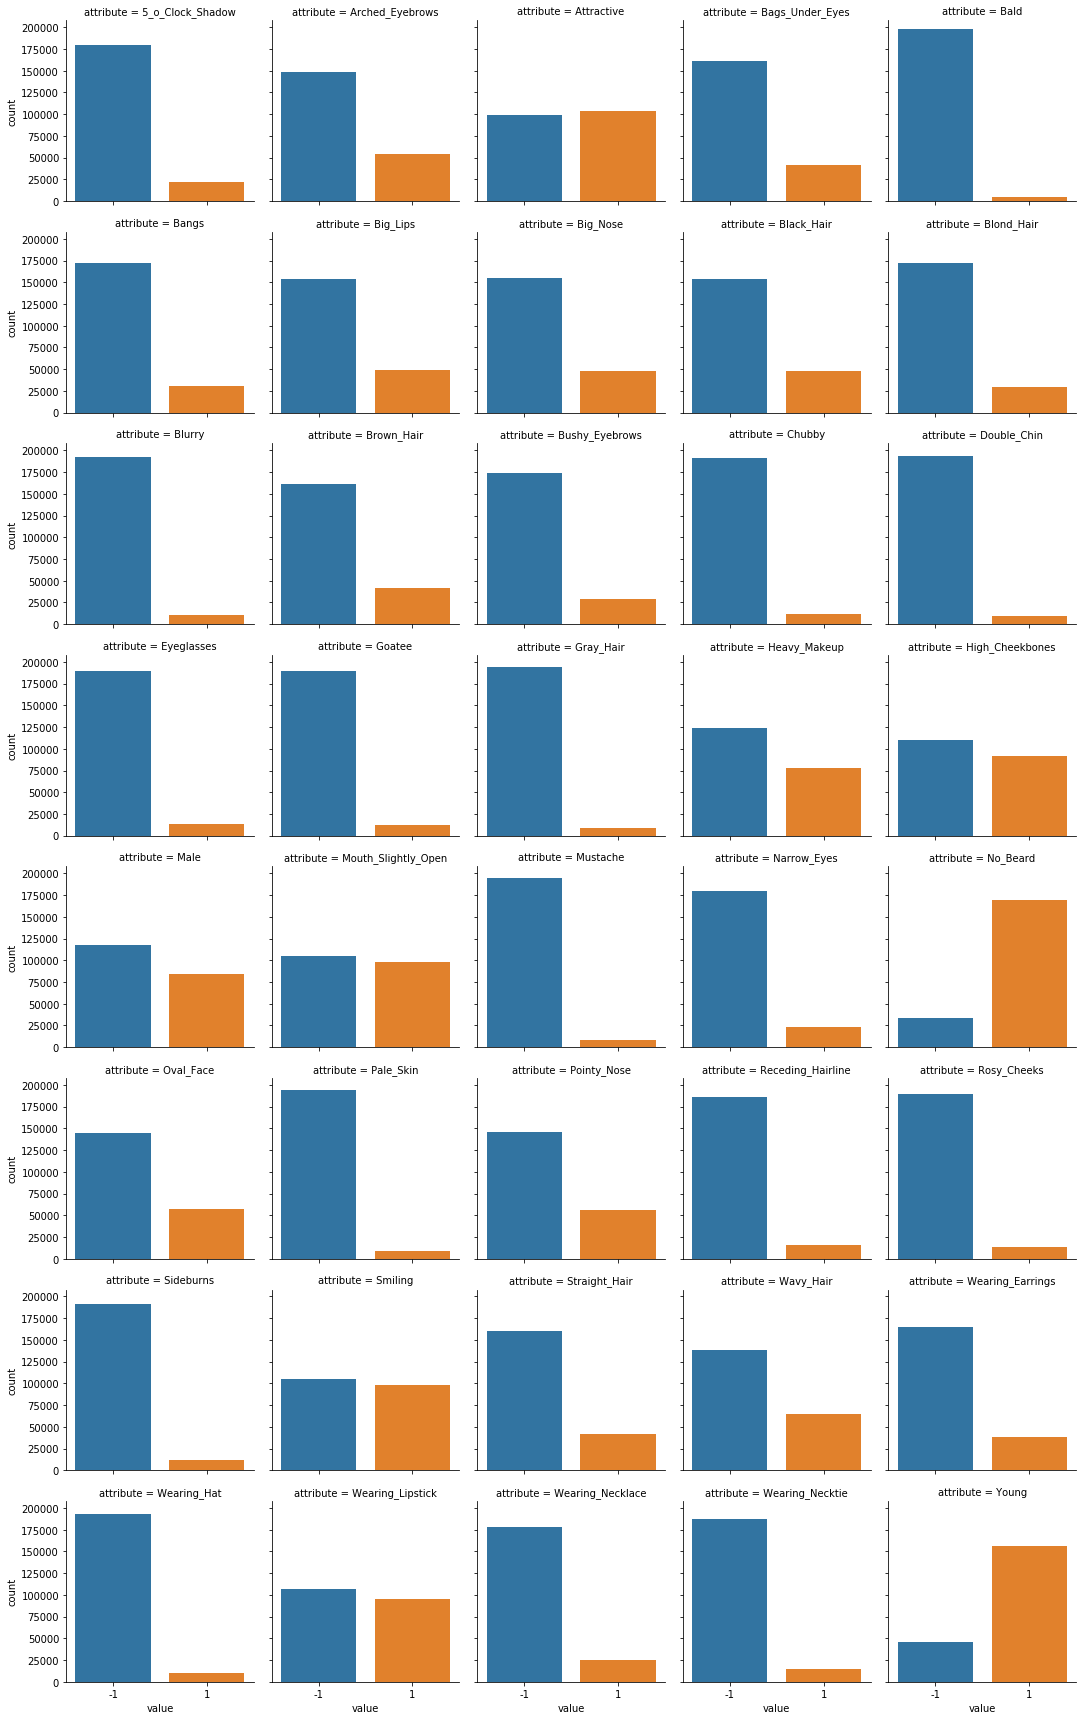

In [7]:
#Boxplots to visualize relative proportion of images that have each attribute
sns.catplot(data=attr_tidy, x='value', y=None, col='attribute', kind='count', col_wrap=5, height=3, aspect=1)

We can already see that a number of attributes are not going to be well represented in this set. This isn't suprising given that many of these attributes are expected to belong to only a smaller percentage of the population (sadly 50% of people don't sport mustaches), but it does give us cases to scrutinize once we have a working model. 

Racial attributes aren't included in the dataset, but given that this data comes from a set of western celebrities, poor minority representation is likely. A quick manual scroll through the image set confirms this, with largely white subjects. This is a problem with most facial datasets I've come across, and it's well documented that this generally leads to worse performance working with BIPOC persons in images.


The next step I will take is to verify what the bounding boxes supplied with the celebA dataset look like on the wild images. It's unlikely that the bounding boxes will be useful to me, but if they closely match facial regions they could be used for fine tuning a pre-trained model.

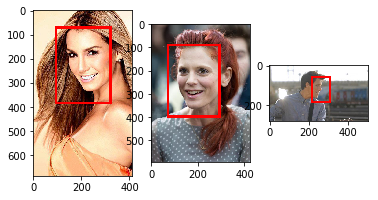

In [11]:
bound_path=r"images\annotations\list_bbox_celeba.txt"
bboxes=pd.read_csv(os.sep.join([pathbase, bound_path]), sep=" +", header=1, nrows=3, engine='python')

#Just drawing 1st 3 images as examples
bound_check_img=['000001.jpg', '000002.jpg', '000003.jpg']
img_wild_base_path = r"images\wild\img_celeba"
f = plt.figure() #generate plot figure 
for i in range(3): 
    bound_temp = bboxes.iloc[i,1:5]
    x1, x2 = bound_temp[0], bound_temp[0] + bound_temp[2]
    y1, y2 = bound_temp[1], bound_temp[1] + bound_temp[3]
    img_path = os.sep.join([pathbase, img_wild_base_path, bound_check_img[i]])
    image = cv2.imread(img_path)
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 10)
    f.add_subplot(1,3,i+1)
    image = image[:, :, ::-1] #Without converting between RGB/BGR, cv2 will display with strong blue hue
    plt.imshow(image)
plt.show()

Right away we see some issues. Given that the bounding box only targets facial features, it will provide little useful information on images where the subject isn't directly facing the camera. For basic image segmentation (rather than facial attribute recognition targeted in the dataset owners' paper), the bounding boxes will be largely useless. Given the time sink of manually creating exact bounding data for portrait images (and the request to use this specific dataset), the available annotations give little opportunity for fine tuning.   
  
The next step will be splitting our dataset into training/validation datasets.

In [44]:
#CelebA dataset includes a training/validation/testing split in the form of a text file with train/eval/test labels. 
#Although we won't be training based on their dataset due to the lack of annotated images, it's still good practice. 
partition_path = r"images\annotations\list_eval_partition.txt"
eval_part = pd.read_csv(os.sep.join([pathbase, partition_path]), sep=" ", header=None ).rename(columns={0:'image', 1:'group'})

#setting paths for original, training, validation and test groupings to shorten code for moving files into their correct folders
image_bp = os.sep.join([pathbase,r"images\wild"]) #image basepath
orig_img_path = os.sep.join([image_bp,'img_celeba']) #original image folder, will be copied to split folders for test/train/val
train_img_path = os.sep.join([image_bp, 'training']) #training images folder
valid_img_path = os.sep.join([image_bp, 'validation']) #validation images folder
test_img_path = os.sep.join([image_bp, 'test']) #test images folder

#only want to run if partitions not already created with all images. Verify 
split_sum_len = len([name for name in os.listdir(train_img_path)]) + len([name for name in os.listdir(valid_img_path)]) + len([name for name in os.listdir(test_img_path)])
if split_sum_len < len(eval_part): 
   for i in range(len(eval_part)):
    #partitioning done through 2nd column. 0=train, 1=eval, 2=test

    if eval_part.iloc[i,1] == 0:
        move(os.sep.join([orig_img_path,eval_part.iloc[i,0]]), os.sep.join([train_img_path, eval_part.iloc[i,0]]))
    elif eval_part.iloc[i,1] == 1:
        move(os.sep.join([orig_img_path,eval_part.iloc[i,0]]), os.sep.join([valid_img_path, eval_part.iloc[i,0]]))
    else:
        move(os.sep.join([orig_img_path,eval_part.iloc[i,0]]), os.sep.join([test_img_path, eval_part.iloc[i,0]]))

With some basic EDA done and everything set up on our local environment, it's time to start creating a model to train with this data. There are two important factors in the choice for this particular problem: varying input sizes and the nature of the problem giving pixel location more importance than a lot of other classifier problems. Using a FCN will help with both issues. In particular, I'll be using an FCN-8 model. The FCN-16 and FCN-32 architectures would work with less accuracy due to the large stride needed when upsampling directly from the last pool layer. In general, both FCN-16 and FCN-32 will generate too coarse of a map.  

FCN-8 architecture can be made using the first layers of a pre-trained VGG-16 model. We should see higher initial skill and a faster skill improvement using pre-trained weights from a VGG-16 model as the encoder. The models will have to diverge once the VGG-16 architecture gets to the fully connected layers. The pre-trained weights from the original VGG-16 model can still be used though, and should be extracted. 

One additional question is the type of segmentation needed: semantic vs instance. The CelebA dataset only has 1 subject in any image, so different instances of the same class aren't necessary. An instance segmentation model could still be used, we just wouldn't get full use out of it. Google has released an open source version of Deep Lab that has been used for semantic segmentation in Pixel's portrait mode, so that will be a very good choice for this problem. Specifically, I will be applying DeepLab V3+